In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')
df.count()

dispatching_base_num      1154112
pickup_datetime           1154112
dropOff_datetime          1154112
PUlocationID               195845
DOlocationID               991892
SR_Flag                         0
Affiliated_base_number    1153227
dtype: int64

In [4]:
df.head(10)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037
6,B00037,2021-01-01 00:18:12,2021-01-01 00:30:04,NaN,91.0,None,B00037
7,B00037,2021-01-01 00:36:15,2021-01-01 00:45:08,NaN,39.0,None,B00037
8,B00037,2021-01-01 00:55:04,2021-01-01 01:13:02,NaN,37.0,None,B00037
9,B00037,2021-01-01 00:48:40,2021-01-01 01:12:02,NaN,39.0,None,B00037


In [5]:
df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')

df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

categorical = ['PUlocationID', 'DOlocationID']

df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.
What's the average trip duration in January?

In [6]:
df.duration.mean()

19.1672240937939

Check the distribution of the duration variable. There are some outliers.
Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
How many records did you drop?

In [7]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [8]:
df.count()

dispatching_base_num      1109826
pickup_datetime           1109826
dropOff_datetime          1109826
PUlocationID               182818
DOlocationID               961919
SR_Flag                         0
Affiliated_base_number    1109053
duration                  1109826
dtype: int64

Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [9]:
df.PUlocationID.isna().sum()

927008

In [10]:
print(df.PUlocationID.isna().sum() / df.count())

dispatching_base_num      0.835273
pickup_datetime           0.835273
dropOff_datetime          0.835273
PUlocationID              5.070660
DOlocationID              0.963707
SR_Flag                        inf
Affiliated_base_number    0.835855
duration                  0.835273
dtype: float64


In [13]:
df['PUlocationID'] = df['PUlocationID'].fillna(-1)
df['DOlocationID'] = df['DOlocationID'].fillna(-1)

/tmp/ipykernel_230718/1051174452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PUlocationID'] = df['PUlocationID'].fillna(-1)
/tmp/ipykernel_230718/1051174452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOlocationID'] = df['DOlocationID'].fillna(-1)


In [14]:
df.head(10)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000
6,B00037,2021-01-01 00:18:12,2021-01-01 00:30:04,-1.0,91.0,None,B00037,11.866667
7,B00037,2021-01-01 00:36:15,2021-01-01 00:45:08,-1.0,39.0,None,B00037,8.883333
8,B00037,2021-01-01 00:55:04,2021-01-01 01:13:02,-1.0,37.0,None,B00037,17.966667
9,B00037,2021-01-01 00:48:40,2021-01-01 01:12:02,-1.0,39.0,None,B00037,23.366667
10,B00037,2021-01-01 00:27:23,2021-01-01 00:29:25,-1.0,72.0,None,B00037,2.033333


Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it

In [24]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient = 'records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

/tmp/ipykernel_230718/3312294369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [27]:
import numpy as np
np.matrix(X_train).shape

(1, 1)

Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

5.52
10.52
15.52
20.52

In [23]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107211805

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


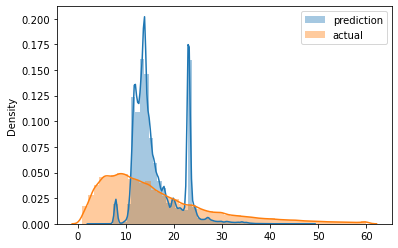

In [28]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [35]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    categorical = ['PUlocationID', 'DOlocationID']

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    df['PUlocationID'] = df['PUlocationID'].fillna(-1)
    df['DOlocationID'] = df['DOlocationID'].fillna(-1)

    categorical = ['PUlocationID', 'DOlocationID']

    #return mean_squared_error(y_train, y_pred, squared=False)
    
    return df

In [32]:
read_dataframe('../data/fhv_tripdata_2021-02.parquet')

10.958228441992793

In [39]:
df_train = read_dataframe('../data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/fhv_tripdata_2021-02.parquet')

In [40]:
len(df_train), len(df_val)

(1109826, 990113)

In [42]:
df_train['PU_DO'] = df_train['PUlocationID'].astype(str) + '_' + df_train['DOlocationID'].astype(str)
df_val['PU_DO'] = df_val['PUlocationID'].astype(str) + '_' + df_val['DOlocationID'].astype(str)

In [43]:
categorical = ['PU_DO']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical ].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [44]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

Q6. Evaluating the model

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.596293625086165